In [6]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Masukkan nama file dataset yang sudah di-upload
dataset_name = "loan_data_2007_2014.csv"  # Ganti dengan nama file dataset Anda

In [8]:
# Load dataset
df = pd.read_csv(dataset_name, low_memory=False)

In [9]:
# Data Understanding
print("Dataset Shape:", df.shape)
print("\nInfo Dataset:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (466285, 75)

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length     

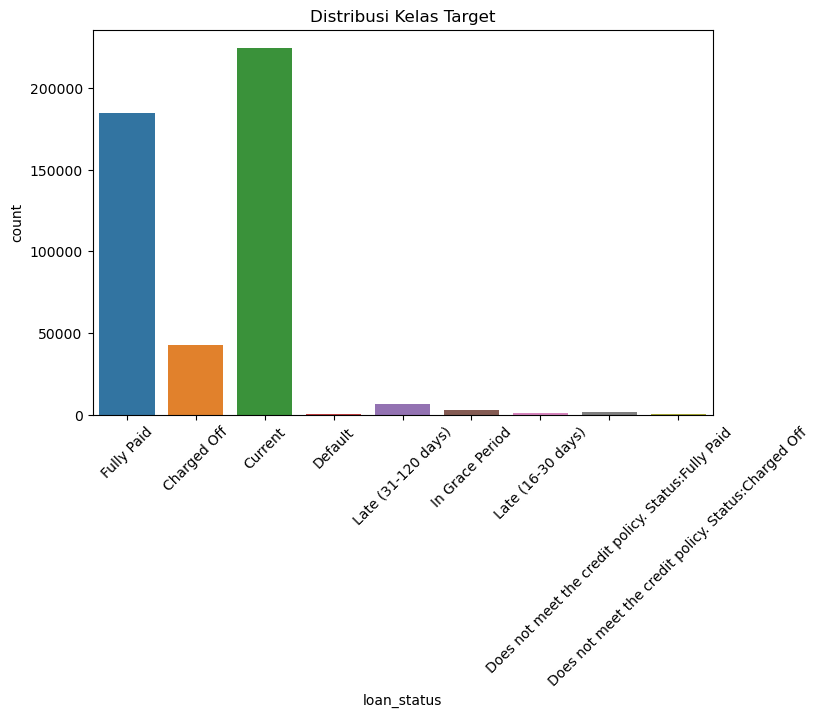

In [10]:
# Visualisasi distribusi kelas target (loan_status)
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=df)
plt.title("Distribusi Kelas Target")
plt.xticks(rotation=45)  # Memutar label agar tidak bertumpuk
plt.show()

In [11]:
# Drop kolom dengan terlalu banyak missing values
missing_threshold = 0.4 * len(df)
df.dropna(thresh=missing_threshold, axis=1, inplace=True)

In [12]:
# Handling missing values
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [13]:
# Encoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

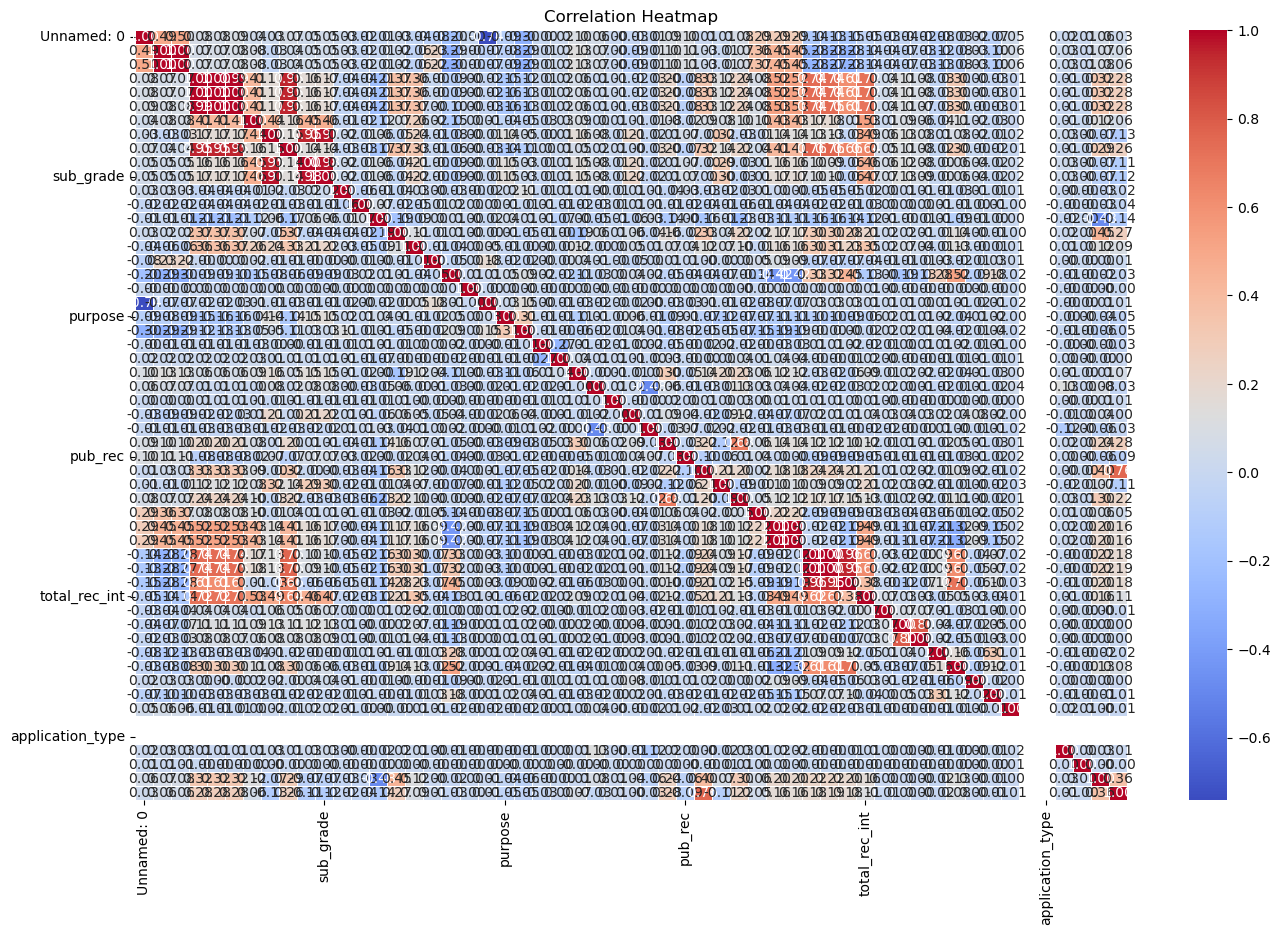

In [14]:
# Exploratory Data Analysis (EDA)
numeric_cols = df.select_dtypes(include=['number']).columns  # Pilih hanya kolom numerik

if len(numeric_cols) == 0:
    print("\n Tidak ada kolom numerik untuk korelasi!")
else:
    corr_matrix = df[numeric_cols].corr()

    if corr_matrix.isna().all().all():
        print("\n Korelasi tidak dapat dihitung karena semua nilai NaN!")
    else:
        plt.figure(figsize=(16, 10))  # Ukuran lebih besar agar lebih jelas
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                    linewidths=0.5, xticklabels=10, yticklabels=10)
        plt.xticks(rotation=90)  # Memutar label agar tidak bertumpuk
        plt.yticks(rotation=0)
        plt.title("Correlation Heatmap")
        plt.show()

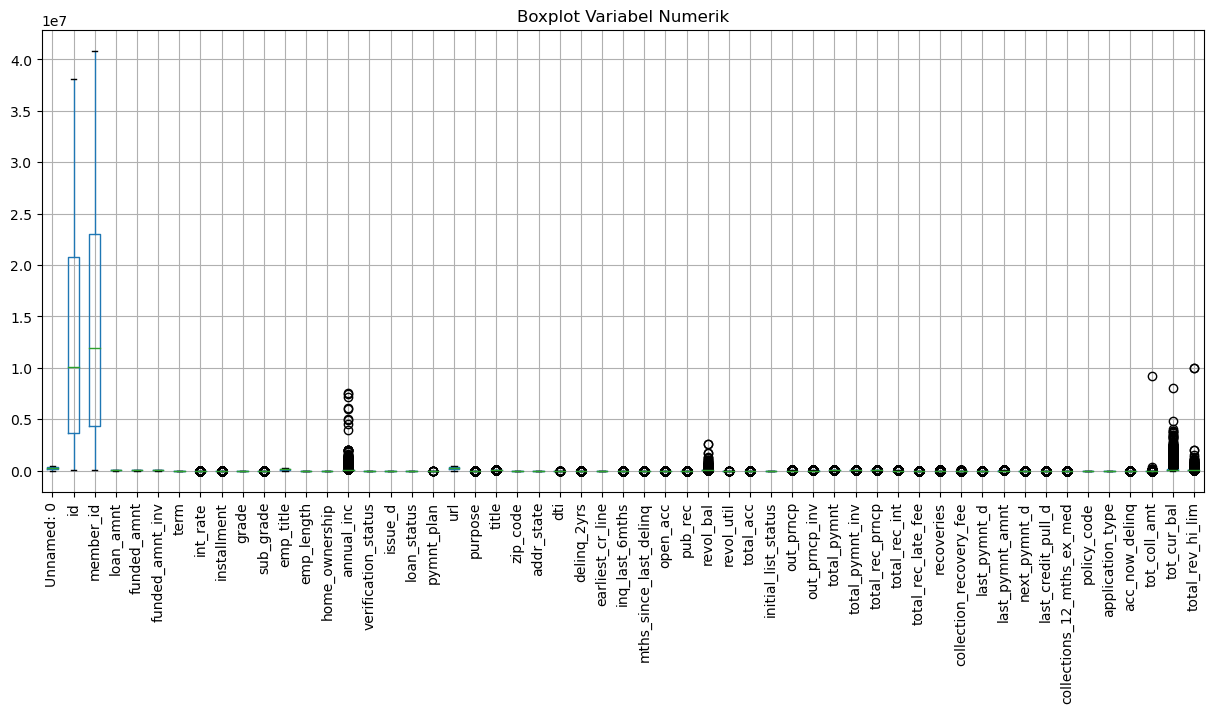

In [15]:
# Boxplot untuk melihat distribusi variabel numerik
plt.figure(figsize=(15, 6))
df[numeric_cols].boxplot(rot=90)
plt.title("Boxplot Variabel Numerik")
plt.show()

In [16]:
# Feature Selection berdasarkan korelasi
correlation_threshold = 0.05
correlation_matrix = df.corr()['loan_status'].abs()
selected_features = correlation_matrix[correlation_matrix > correlation_threshold].index.tolist()
selected_features.remove('loan_status') #Kecuali target variable

In [17]:
# Definisi fitur dan target
X = df[selected_features]
y = df['loan_status']

In [18]:
# Split dataset (80% training - 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
# Standardization (Scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Model Training
log_reg = LogisticRegression()
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

models = {"Logistic Regression": log_reg, "Random Forest": rf_clf, "XGBoost": xgb_clf}
for name, model in models.items():
    model.fit(X_train, y_train)

In [21]:
# Hyperparameter Tuning untuk XGBoost
param_grid = {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [100, 200]}
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

In [22]:
# Model Evaluation Function
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

def evaluate_model(model, X_test, y_test, model_name):
    """
    Fungsi untuk mengevaluasi model dengan metrik Accuracy, ROC-AUC, dan Classification Report.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Menyesuaikan ROC-AUC untuk binary atau multi-class
    if len(set(y_test)) > 2:  # Jika multi-class
        roc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")
    else:  # Jika binary classification
        roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"{model_name} - Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}")
    print(classification_report(y_test, y_pred))

In [23]:
# Evaluasi Model
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")
evaluate_model(rf_clf, X_test, y_test, "Random Forest")
evaluate_model(best_xgb, X_test, y_test, "XGBoost (Tuned)")

Logistic Regression - Accuracy: 0.9764, ROC-AUC: 0.9523
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8495
           1       0.97      0.99      0.98     44845
           2       0.67      0.01      0.02       166
           3       0.81      0.48      0.60       152
           4       0.77      0.43      0.55       398
           5       0.98      1.00      0.99     36948
           6       0.00      0.00      0.00       629
           7       0.00      0.00      0.00       244
           8       0.96      0.74      0.84      1380

    accuracy                           0.98     93257
   macro avg       0.68      0.52      0.55     93257
weighted avg       0.97      0.98      0.97     93257

Random Forest - Accuracy: 0.9860, ROC-AUC: 0.9616
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8495
           1       0.97      1.00      0.99     44845
           2       0.99   

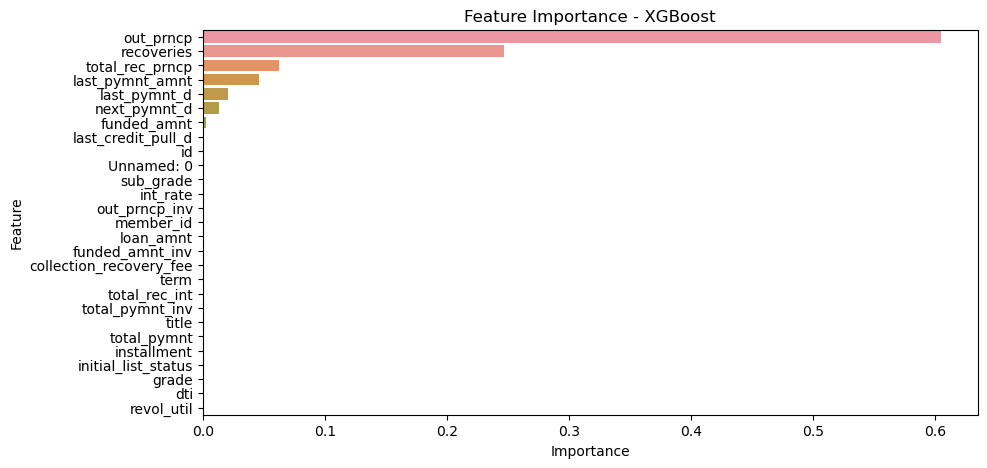

In [24]:
# Feature Importance dari XGBoost
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': best_xgb.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance - XGBoost")
plt.show()